In [3]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
sys.path.append("../../lexrank/")
from lexrank.lexrank import  degree_centrality_scores
from modules import utils,modeling

from sentence_transformers import SentenceTransformer,util
import plotly.express as px
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score,make_scorer

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from sentence_transformers import models

from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from modules.NLPipe import NLPipe

from modules.modeling import scatter_plot,bar_plot

pd.set_option('display.max_colwidth', 1000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=250)

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False, 
                               pooling_mode_max_tokens=False) # 784 x 1
# join BERT model and pooling to get the sentence transformer
embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

### Let's load the data and do some minimal prep.

- removing mediathek departmant as these are videos and podcast
- filtering out articles shorter than 100 characters

In [61]:
df = pd.read_csv("../data/welt_articles.csv", index_col=0)
df = df[df.department != "mediathek"]
df = df[df.text.str.len() > 250]

df = df.rename(columns={"date": "created_at"})
df = df.sort_values(by='created_at',ascending=False)
df.created_at = pd.to_datetime(df.created_at, dayfirst=True)
df.created_at = df.created_at.apply(lambda x: x.date()).apply(str)
df = df.rename(columns={"title": "headline"})

df = df.head(1500)
"We have {} articles. ".format(df.shape[0],df.text.apply(lambda x: x.split(" ")))

#### For some extra performance let's join headline with text as it caries a lot of info.
df.text = df.headline + ". " + df.text
####

In [62]:
pdf = utils.preprocess_articles_for_bert(df,"text",lower=True)

for nr in  range(50,55):
    print(df.text.values[nr][:100]," \n -> ",pdf[nr][:150]+"...")
    print()

Damit Ruhe ist – „Querdenker“ werden zuerst geimpft. Wer soll als Erstes den von Biontech und Pfizer  
 ->  damit ruhe ist querdenker werden zuerst geimpft. wer soll als erstes den von biontech und pfizer entwickelten impfstoff gegen das neuartige coronaviru...

Frauen können Krisen besser bewältigen. 50 Millionen Infizierte, über 1,1 Millionen Tote – Covid-19   
 ->  frauen können krisen besser bewältigen. 50 millionen infizierte, über 1,1 millionen tote covid-19 hat die welt erfasst, schürt ängste, spaltet gesells...

Deutscher erstattet Anzeige gegen syrisches Regime wegen Folter. Erstmals geht ein deutscher Staatsb  
 ->  deutscher erstattet anzeige gegen syrisches regime wegen folter. erstmals geht ein deutscher staatsbürger juristisch gegen syrische funktionäre wegen ...

Abends bei einem Angehörigen der Risikogruppe. Früher, also bevor es mit Corona losging, kam Efraim   
 ->  abends bei einem angehörigen der risikogruppe. früher, also bevor es mit corona losging, kam efraim hab

In [63]:
df.head()

,headline,seo_title,department,text,created_at,importer
cms_id,,,,,,
160419841,Als Hitler sich den Oberbefehl über das Heer griff,Schlacht um Moskau: Als Hitler sich den Oberbefehl über das Heer griff,geschichte,"Als Hitler sich den Oberbefehl über das Heer griff. Wer Schuld trägt, tut gut daran, einen Sündenbock zu haben. Adolf Hitler hielt wenig bis nichts von den älteren Generälen der Wehrmacht, die schon im Ersten Weltkrieg meist als Stabsoffiziere hinter der Front eingesetzt waren. Nützlich waren sie ihm trotzdem – manchmal als Experten wie der hervorragende Planer Franz Halder, Generalstabschef des Heeres. Manchmal als erfahrene Strategen wie Gerd von Rundstedt oder Günther von Kluge. Manchmal aber eben auch nur als Verantwortliche, die man im günstigen Moment absetzen konnte. Viel spricht dafür, dass Hitler genau aus diesem Grund den formal obersten Soldaten des deutschen Heeres, Generalfeldmarschall Walther von Brauchitsch, bis Ende 1941 im Amt beließ. Er stand auf derselben Stufe wie Generaladmiral Erich Raeder und Generalfeldmarschall Erhard Milch, der zweite Mann der Luftwaffe; dessen Vorgesetzter Hermann Göring war aufgrund seiner anderen Funktionen in der Hierarchie höher anges...",2020-11-10,welt
219727214,Neue Corona-Fälle im Weißen Haus – US-Minister positiv getestet,USA: Nach Trumps Wahlparty gibt es zwei neue Corona-Fälle im Weißen Haus,newsteam,"Neue Corona-Fälle im Weißen Haus – US-Minister positiv getestet. Im Umfeld von US-Präsident Donald Trump gibt es laut US-Medienberichten zwei weitere Corona-Infektionsfälle: Bauminister Ben Carson sei wegen seiner Infektion in das Militärkrankenhaus Walter Reid vor den Toren Washingtons gebracht worden, in dem auch Trump selbst wegen Covid-19 behandelt worden war. Das hatte zuerst der Sender ABC am Montag (Ortszeit). Positiv getestet wurde laut dem Sender NBC auch der ranghohe Präsidentenberater David Bossie.Carsons stellvertretender Stabschef Coalter Baker sagte dem Sender NPR, der Minister sei guter Dinge und „froh, Zugang zu wirksamen Therapien“ zu haben, die seine Genesung beschleunigten. Der 69-jährige Carson hatte am Dienstag vergangener Woche mit weiteren Mitarbeitern des Weißen Hauses die Stimmauszählung nach der US-Präsidentschaftswahl verfolgt.Der 55-jährige Trump-Berater Bossie hatte ebenfalls an der Veranstaltung nach der Wahl teilgenommen. Laut NBC News isolierte er si...",2020-11-10,welt
219758712,"Chaos ist wirklich das letzte, was wir in der Pandemie noch brauchen","Corona-Impfstrategie: Chaos ist das letzte, was wir jetzt brauchen",debatte,"Chaos ist wirklich das letzte, was wir in der Pandemie noch brauchen. An dem Tag, an dem mit den ersten guten Ergebnissen des Impfstoffherstellers Biontech die Hoffnung auf ein schnelles Ende der Pandemie aufflackert, verkündet die Bundesregierung ihre Corona-Impfstrategie. Das ist schön. Ärzte, Risikogruppen und systemrelevante Gruppen sollen die ersten sein, die geimpft werden – zu diesem Schluss sind nun Ethiker, Juristen, Ärzte und Epidemiologen gekommen. Schön, dass das noch mal gesagt worden ist. Allerdings ist diese Reihenfolge bereits seit Monaten klar.Das „Wer?“ zu klären ist wichtig, keine Frage. Aber es wäre auch schön gewesen, wenn etwas über das „Wie?“ bekannt gegeben worden wäre. Schließlich könnte das Impfen im besten Falle bereits in zwei Monaten beginnen. Die Frage der Verteilung des VakzinsWarum also wird noch nichts darüber gesagt, wie die Verteilung des Vakzins funktionieren soll? Außer, dass derzeit Impfzentren aufgebaut werden, ist nichts bekannt. Wird es nur ...",2020-11-10,welt
219754260,Hamburg ändert Strategie der Corona-Nachverfolgung,Coronavirus: Hamburg ändert Strategie der Corona-Nachverfolgung,regional,"Hamburg ändert Strategie der Corona-Nachverfolgung. Die Hoffnung auf einen neuen Impfstoff in nicht allzu ferner Zukunft, gleichzeitig aber auch die sich zuspitzende Lage in den Kliniken und in den Gesundheitsämtern – in diesem Spannungsfeld bewegt sich derzeit auch die Hamburger Poli

## Document embedding and clustering

In [91]:
nlpipe = NLPipe(df)
nlpipe._store_headlines() 
nlpipe._store_created_at()

embedded = nlpipe.cleantext().embed(batch_size=50).normalize()
cluster_results = embedded.reduce_dim().cluster_hdbscan(cluster_selection_method="leaf",cluster_selection_epsilon= 0.54,) # cluster labels 
viz_dimensions = embedded.reduce_dim( model_path="../models/bert-german-dbmdz-uncased-sentence-stsb/umap_viz_100_19-neighbors_0.01-min-dist.pkl").value() # 


ctr=Counter(cluster_results.value()).most_common(25)
print("Outliers {}".format(dict(Counter(cluster_results.value()))["-1"]),set(cluster_results.value()))


--- UMAP Loaded in 5.568455934524536 seconds 
--- Reduced dimensionality to (1500, 384) .
>> --- Done in 0.8 seconds ---
--- UMAP Loaded in 3.3110969066619873 seconds 
--- Reduced dimensionality to (1500, 2) .
Outliers 145 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, -1}


## Preprocesing clustring results for viz
Linking the encodings with creation date and headline for viz

In [67]:
res = pd.DataFrame(viz_dimensions,columns=['x', 'y'])

res['labels'] = cluster_results.value()
res['headline'] = df.seo_title.values #nlpipe.data.headlines
res['created_at'] = nlpipe.data.created_at

# Summarizing the clusters

In [68]:

docs_df = pd.DataFrame(zip(embedded.data.pdf,embedded.data.headlines), columns=["Doc","Headline"])
docs_df['Topic'] = cluster_results.value()
docs_df['Doc_ID'] = df.index.values
docs_per_topic = docs_df.groupby(['Topic'], as_index = True).agg({'Doc': ' '.join,'Headline': ' '.join})# For every topic collect all the article and join their texts (preprocessed) , raw texts, 


docs_per_topic.head(2)

,Doc,Headline
Topic,,
-1,"So meistern Sie den gefürchteten Big-Five-Test der Personaler. Mehrere Bewerber in einem Raum? Das gibt es bei der Deutschen Bahn nicht mehr. Kurz nach Beginn des Lockdowns im Frühjahr, als viele Firmen einen Großteil ihrer Mitarbeiter ins Homeoffice schickten, stellte das Unternehmen kurzfristig seine Bewerberauswahl um. Das klassische Assessment-Center, bei dem mehrere Kandidaten vor Ort über einen Tag hinweg die verschiedensten Aufgaben lösen müssen, ist damit Geschichte.Seit Mitte April steht bei der Bahn alles unter dem Motto online oder nichts. 16 digitale Assessment-Center haben die Mitarbeiter der Personalgewinnung für die zukünftigen Trainees meist Berufseinsteiger, die frisch von der Universität kommen seitdem organisiert. 31 freie Stellen wurden so.Damit ist die Deutsche Bahn nicht allein. In vielen Branchen müssen Unternehmen derzeit in Sachen Bewerberauswahl umplanen. Um Jobkandidaten angemessen zu testen, scheint ein digitales Assessment-Center der einfachste Weg. Auc...",So meistern Sie den gefürchteten „Big-Five“-Test der Personaler Wie ein Fußballer die britische Regierung beschämt Schluss mit lustig? „Ich werde dieses Gespräch mit meinem Opa niemals vergessen“ Konziliant oder Kommunistin? Das wahre Gesicht der Kamala Harris Was den Deutschen an ihrer Nationalmannschaft nicht passt „Das globale Energiesystem wird nicht über Nacht klimaneutral werden“ Europa holt zum „Gegenschlag“ aus Gegen den Strom Schriftsteller zieht eine Art Hassliebe ins Hotel Der Windhund Monika Maron und das Gespenst des Mainstreams Das zweite Schweden Noch vor Machtübernahme schwört Biden Amerika auf „dunklen Winter“ ein Warum Sport in der Schwangerschaft sinnvoll ist Watzke forciert Moukokos Bundesliga-Debüt Starship SN8 ist der neue Clou des Elon Musk Wie antisemitisch sind deutsche Klassenzimmer? Die Demokraten-Elite kennt Trump-Wähler nur aus CNN-Berichten Angebote am Black Friday - so finden Sie echte Schnäppchen Mit diesem Geheimauftrag modernisiert Siemens einen ga...
0,"Das Joe-Biden-Problem des Boris Johnson. Der Schaden, den die Trump-Jahre dem Ansehen der USA auf der Welt zugefügt haben, ist immens. Eine gespaltene Nation sind die USA obendrein. Amerika zu versöhnen wird die conditio sine qua non des neuen Präsidenten Joe Biden für den Erfolg seiner Amtszeit sein.Freilich, dieser Satz, in Großbritannien gesprochen, klingt wohlfeil. Die Briten erleiden schon seit Jahren das Los selbst zerfleischender Uneinigkeit.Der Brexit, das knappe Ergebnis einer Volksbefragung, hat noch immer nicht die letzte Hürde genommen, den Abschluss eines Freihandelsabkommens zwischen dem Vereinigten Königreich und der Europäischen Union.Von den über vier Jahren seit jenem Juni 2016 sind gerade noch sieben Wochen übrig geblieben, um ein Ergebnis zu erzielen. Ohne ein solches zögen am 31. Dezember die Nebel verstärkter Unberechenbarkeit über der Insel, und das mitten in der Corona-Krise.Das ist möglicherweise eine Herausforderung zu viel für das berühmte Keep calm and c...",Das Joe-Biden-Problem des Boris Johnson Irland will neue Corona-Hilfen der EU verhindern Wie Corbyn die Arbeiterpartei zu einem Hort des Judenhasses machte


In [69]:
def lexrank_summarize(cluster_doc):
    sentences = nltk.sent_tokenize(cluster_doc)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = embedder.encode(sentences, convert_to_tensor=True)

    #Compute the pair-wise cosine similarities
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy()

    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    return " ".join([sentences[idx].strip() for idx in most_central_sentence_indices[0:1]])
    

## Cluster-based TF-IDF + Cluster Summary

In [86]:
tf_idf, count = utils.c_tf_idf(docs_per_topic.Doc.values, m=len(embedded.data.pdf),ngram_range=(1,2),remove_stop_words=True)
top_n_words = utils.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic.reset_index(), n=20)
top_6_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:7]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])
top_6_words_per_topic["Topic"]=top_6_words_per_topic["Topic"].apply(int)
topic_sizes = utils.extract_topic_sizes(docs_df)
#top_6_words_per_topic["Summary"] = top_6_words_per_topic.Topic.apply(lambda x: lexrank_summarize(docs_per_topic.loc[x].Doc) )
top_6_words_per_topic=top_6_words_per_topic.set_index("Topic")


top_6_words_per_topic

Number of stopwords 607


,top_n_words
Topic,
-1,harris | siemens | adventskalender | friday | black friday | black | khosrowshahi
0,labour | corbyn | johnson | brexit | boris johnson | irland | starmer
1,kipchoge | nikic | laufen | beck | ironman | freiwasser | schwimmen
2,iphone | google | apple | smartphone | ohrhörer | tablet | ipad
3,hawk | lakers | skateboard | hager | las vegas | vegas | las
4,zverev | sharypova | van | price | tuberville | nummer | finale
5,alber | kepler | bevölkerungswachstum | gesänge | benin | finnwale | afrikanischen
6,blue moon | moon | vollmond | blue | südtirol | wahlbeteiligung | seuche
7,argentinien | kolumbien | fernandez | zeta | salinas | lauer perez | lauer


Outliers 145


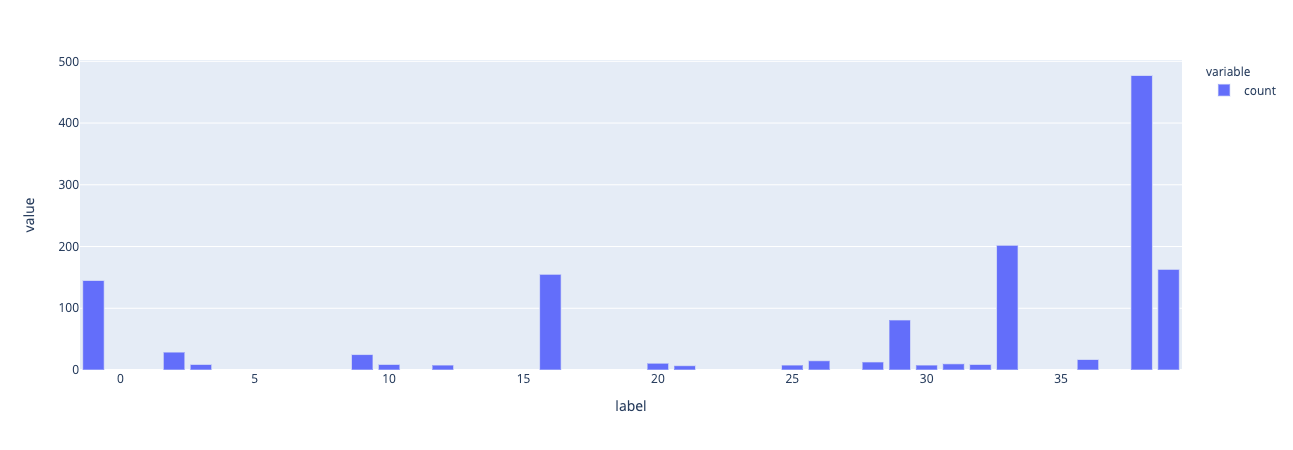

In [90]:

pd.DataFrame(ctr,columns=['label','count']).set_index("label").plot(kind='bar')

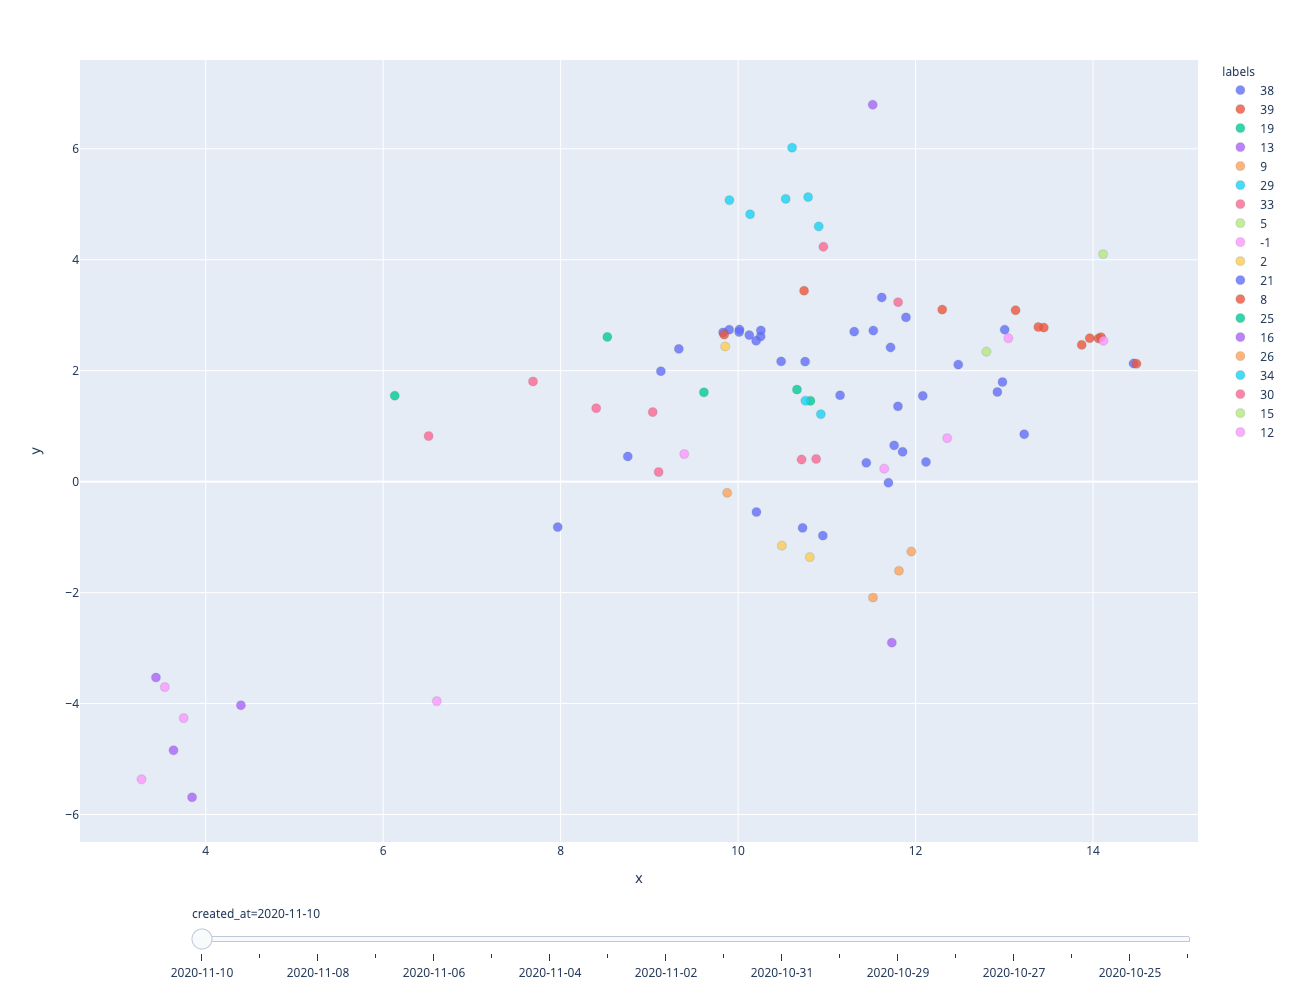

In [72]:
res.labels=res.labels.apply(str)
top_6_words_per_topic.index = top_6_words_per_topic.reset_index().Topic.apply(str)
_res = pd.merge(res,top_6_words_per_topic.reset_index(),left_on="labels",right_on="Topic")

#import textwrap

#_res["Summary"]=_res["Summary"].apply(
#    lambda t: "<br>".join(textwrap.wrap(t))
#)
scatter_plot(_res,animation_frame="created_at",hover_data=["created_at","top_n_words"])

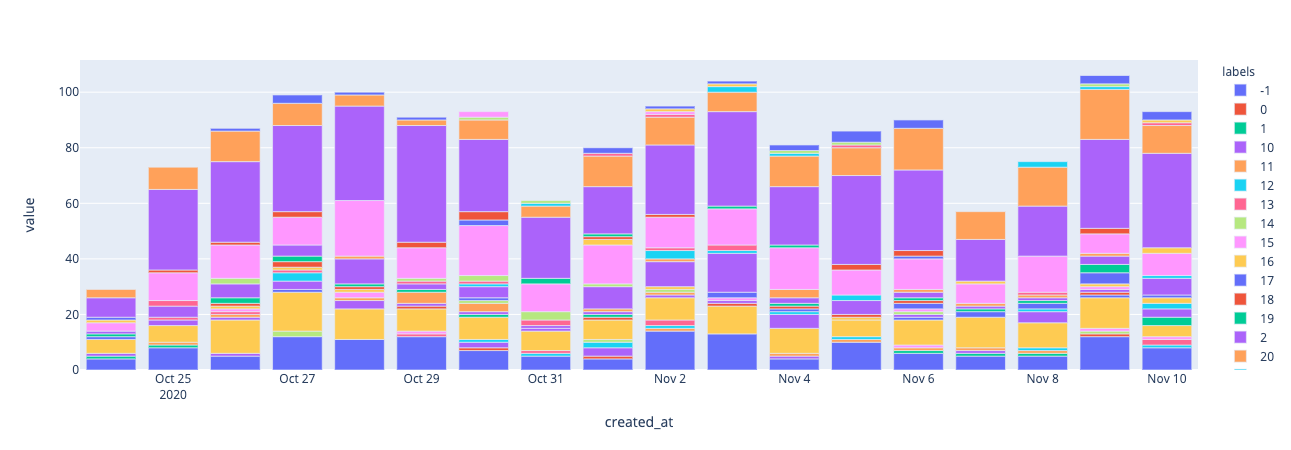

In [73]:
bar_plot(_res)

In [74]:
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=250)

# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
#                                pooling_mode_mean_tokens=True,
#                                pooling_mode_cls_token=False,
#                                pooling_mode_max_tokens=False)

# # join BERT model and pooling to get the sentence transformer
# embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# # Corpus with example sentences
# corpus = pdf
# corpus_embeddings = embedder.encode(corpus)

# # Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# # Perform kmean clustering
# clustering_model = AgglomerativeClustering(n_clusters=None ,affinity='cosine', linkage='average', distance_threshold=0.4)
# clustering_model.fit(corpus_embeddings)
# cluster_assignment = clustering_model.labels_


In [ ]:
_res.to_csv("./ds-18-nov.csv")

In [24]:
res

,x,y,labels,headline,created_at
0,11.957416,3.093269,-1,„Müssen jeden Tag auch in Deutschland mit islamistischem Anschlag rechnen“,2020-11-05
1,10.944194,4.864766,31,Welche Rolle spielte „Monitor“ beim Bad-Kleinen-Skandal?,2020-11-05
2,10.357701,2.542064,51,Corona-Schnelltests zuerst für Altenheime,2020-11-05
3,12.859134,3.249158,32,Erdogan und die Helden von Wien,2020-11-05
4,10.779376,1.727527,46,Welche Sportarten sind noch erlaubt?,2020-11-05
...,...,...,...,...,...
495,12.731773,2.374354,2,So will die Regierung die Verschlüsselung umgehen,2020-11-10
496,8.995604,1.403342,43,"Eine Uhr, deren Klang ihren Träger durch den Alltag begleitet",2020-11-10
497,9.818734,5.114224,32,Kranke Frau getötet - aus Liebe? Ein Prozess offenbart das Pflegedilemma,2020-11-10
498,13.885605,2.461369,11,„Kein Mut“ - Trump beklagt Zeitpunkt der Bekanntgabe guter Impfstoff-Nachrichten,2020-11-10


149

145